In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the avocado data as a pandas data frame
data = pd.read_csv('avocado.csv')

In [3]:
# Create two data frames - one for conventional avocados, another for organic avocados
conv_data = data.drop(labels = ['Unnamed: 0'], axis = 1)[data['type'] == 'conventional']
org_data = data.drop(labels = ['Unnamed: 0'], axis = 1)[data['type'] == 'organic']

In [7]:
# Turn the conventional avocado data frame into a time-series data frame
# For each size (small, large, XL) the avocado sales are split into single avocado sales and bagged avocado sales
# This will combine both of these sources of sales into one number for each avocado size

conv_data['Date'] = pd.to_datetime(conv_data['Date'])
cleaned_data2 = conv_data.copy()
cleaned_data2['4046'] = conv_data['4046'] + conv_data['Small Bags']
cleaned_data2['4225'] = conv_data['4225'] + conv_data['Large Bags']
cleaned_data2['4770'] = conv_data['4770'] + conv_data['XLarge Bags']
cleaned_data2 = cleaned_data2.drop(labels = ['Small Bags','Large Bags','XLarge Bags'], axis = 1)

ts_data = cleaned_data2[cleaned_data2['region']=='TotalUS'][['Date','4046','4225','4770']]

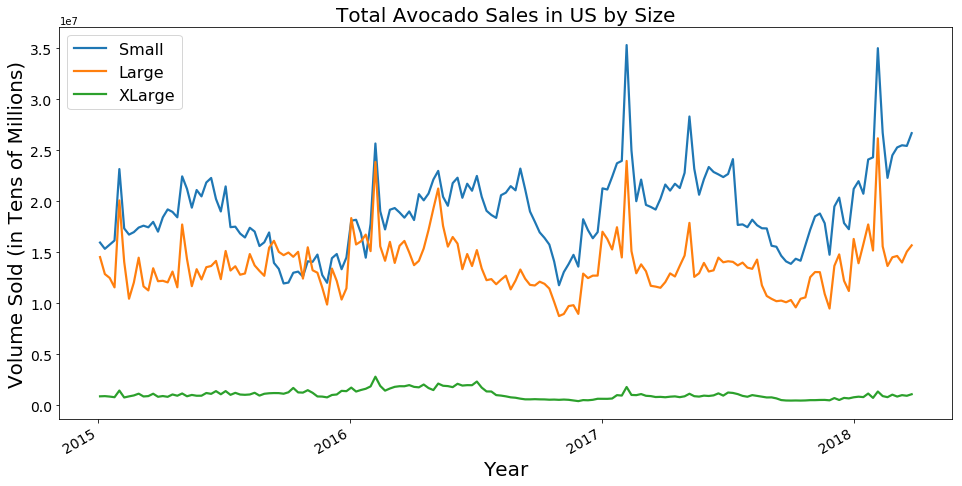

In [8]:
# Plot the total conventional avocado sales in US as a time-series plot

ax = ts_data.set_index('Date').plot(figsize=(16,8), fontsize=14, lw=2.2,
                                    xticks=[pd.to_datetime('2015-01'),pd.to_datetime('2016-01'),
                                            pd.to_datetime('2017-01'),pd.to_datetime('2018-01')])
ax.set_ylabel('Volume Sold (in Tens of Millions)', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.set_title('Total Avocado Sales in US by Size', fontsize=20)
ax.legend(['Small','Large','XLarge'], fontsize=16)

In [12]:
# In the original data, there are cities within the 'region' variable
# The data is filtered to only contain the regions defined by the Hass Avocado Board
# This allows for analysis on a regional-basis

remove_regions = ['TotalUS', 'West', 'SouthCentral', 'Northeast', 'Southeast', 'Plains', 'Midsouth', 'GreatLakes', 'California']
indices_to_remove = cleaned_data2[cleaned_data2['region'].isin(remove_regions)].index
agg_conv_data = cleaned_data2.loc[indices_to_remove]

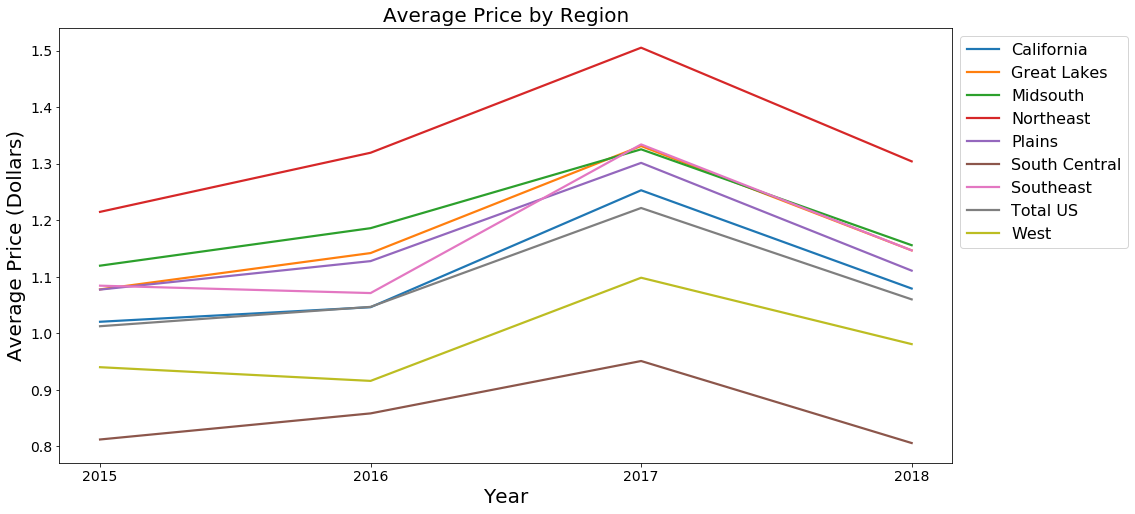

In [152]:
# Plots the average price of all avocados by region

ax = agg_conv_data.drop(labels=['Total Volume','4046','4225','4770','Total Bags'],
                        axis=1).groupby(['region','year']).mean().unstack(level=0).plot(xticks = [2015,2016,2017,2018],
                                                                                        figsize=(16,8), fontsize=14, lw=2.2)
ax.set_ylabel('Average Price (Dollars)', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.set_title('Average Price by Region', fontsize=20)
ax.legend(['California','Great Lakes','Midsouth', 'Northeast','Plains','South Central','Southeast','Total US','West'],
          fontsize=16, bbox_to_anchor=(1, 1))

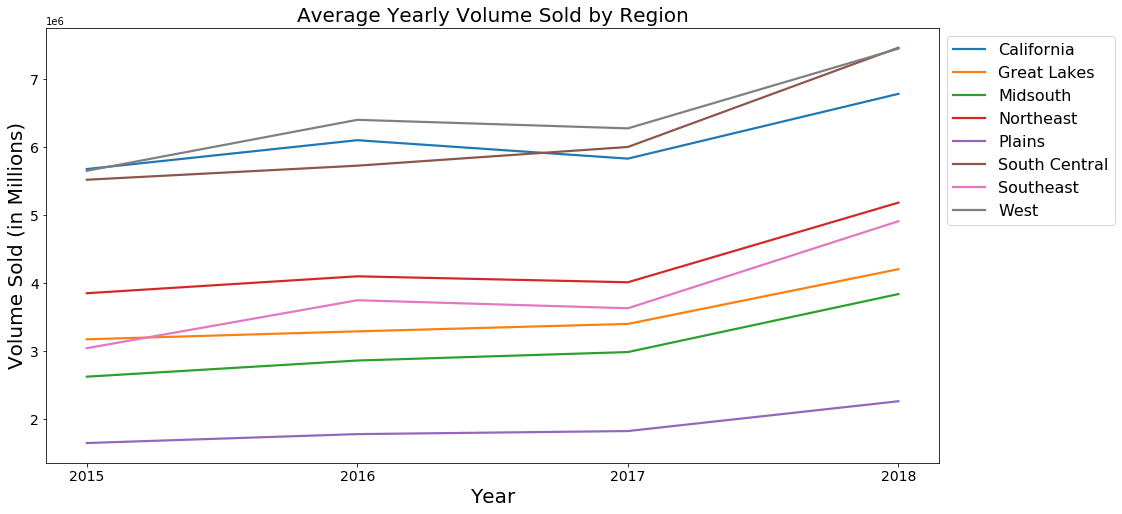

In [153]:
# Plots the yearly average volume of avocados sold by region

ax = agg_conv_data[agg_conv_data['region']!='TotalUS'].drop(labels=['AveragePrice','4046','4225','4770','Total Bags'],
                        axis=1).groupby(['region','year']).mean().unstack(level=0).plot(xticks = [2015,2016,2017,2018],
                                                                                        figsize=(16,8), fontsize=14, lw=2.2)
ax.set_ylabel('Volume Sold (in Millions)', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.set_title('Average Yearly Volume Sold by Region', fontsize=20)
ax.legend(['California','Great Lakes','Midsouth', 'Northeast','Plains','South Central','Southeast','West'],
          fontsize=16, bbox_to_anchor=(1, 1))
ax.ticklabel_format(axis='y',style='sci', scilimits=(0,0))

In [13]:
# Calculation of unmet demand: 
# For our avocado project, we want to enter the market at a price point of $0.80
# In order to calculate how much demand is not met by the supply, we filtered out all of the data below this price
# then found the maximum demand of the remaining data. We then subtracted our forecasted (total mean) demand from
# this maximum to determine how much demand is not met by current suppliers.

window = agg_conv_data[agg_conv_data['AveragePrice'] > .8]
max_demand = window.groupby('region').max()['Total Volume']
unmet_demand = pd.Series()
for i in max_demand.index:
    ud = max_demand[i] - agg_conv_data[agg_conv_data['region'] == i]['Total Volume']
    unmet_demand = unmet_demand.append(ud)
agg_conv_data['Unmet Demand'] = unmet_demand.sort_index()
agg_conv_data.groupby('region').sum()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,year,Unmet Demand
region,,,,,,,,
California,186.82,1.003597e+09,6.141598e+08,3.523247e+08,3.711234e+07,2.378415e+08,340729,5.228417e+08
GreatLakes,199.74,5.675679e+08,2.104877e+08,3.006134e+08,5.646676e+07,1.680633e+08,340729,6.314474e+08
Midsouth,204.01,4.903689e+08,2.368217e+08,2.335710e+08,1.997613e+07,1.467037e+08,340729,4.030349e+08
Northeast,227.21,6.890548e+08,1.919692e+08,4.890857e+08,7.999896e+06,1.809139e+08,340729,5.799071e+08
Plains,196.97,3.029127e+08,2.088811e+08,9.063100e+07,3.400603e+06,7.352393e+07,340729,2.575750e+08
SouthCentral,146.93,9.931612e+08,7.038222e+08,2.643206e+08,2.501833e+07,2.220515e+08,340729,3.458087e+08
Southeast,196.55,6.051988e+08,4.405446e+08,1.590542e+08,5.599956e+06,1.752940e+08,340729,6.700649e+08
TotalUS,184.55,5.701222e+09,3.212885e+09,2.311624e+09,1.767123e+08,1.553193e+09,340729,4.862233e+09
West,166.48,1.049361e+09,6.061989e+08,4.220234e+08,2.113833e+07,3.488013e+08,340729,7.361339e+08


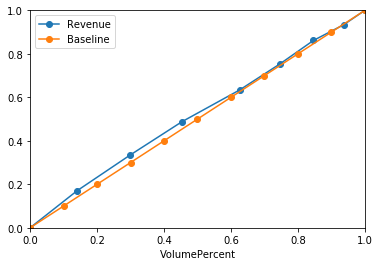

In [15]:
# Set up the values for calculating lift later on

agg_conv_data['Revenue'] = agg_conv_data['AveragePrice']*agg_conv_data['Unmet Demand']
for_lift = agg_conv_data[agg_conv_data['year']==2016].groupby('region').sum().sort_values('Revenue', ascending=False)
for_lift = for_lift.drop('TotalUS')
total_values = for_lift.apply(sum)
for_lift = for_lift.drop(['Total Volume','AveragePrice','4046','4225','4770','Total Bags','year'], axis=1)
for_lift['VolumePercent'] = for_lift['Unmet Demand']/total_values['Unmet Demand']
for_lift['RevenuePercent'] = for_lift['Revenue']/total_values['Revenue']
chart_values = for_lift.apply(cumsum).reset_index().drop(['Unmet Demand','Revenue','region'], axis=1)
chart_values.loc[-1] = [0,0]
ax = chart_values.sort_index().set_index('VolumePercent').plot(xlim=[0,1], ylim=[0,1],marker='o')
t = np.arange(0., 1.1, 0.1)
ax.plot(t,t, marker='o', label='Baseline')
ax.legend(['Revenue','Baseline'])

Text(0.5,1,'Revenue by Regions Sold to')

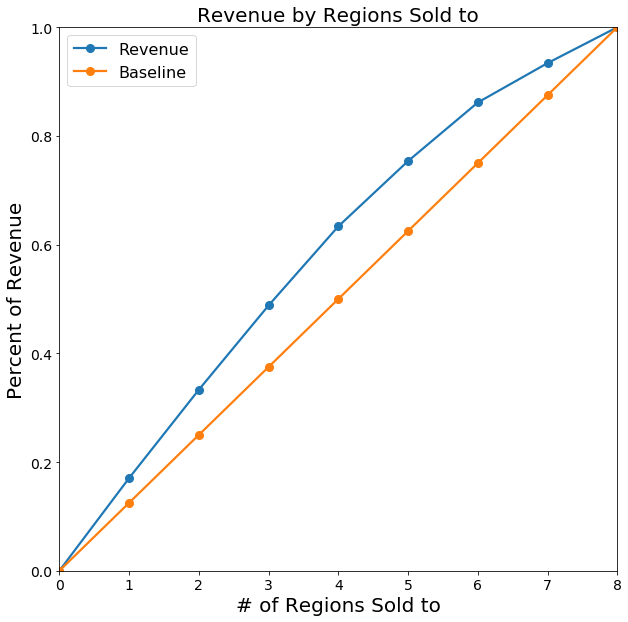

In [16]:
# A lift curve is generated to determine how much of the total demand is met when implementing a by-region
# targeting strategy. This plot implies that it would be best to sell to the top 5 or 6 regions

chart_values2 = chart_values.copy()
chart_values2.index += 1
ax = chart_values2.sort_index().drop(labels='VolumePercent',axis=1).plot(xlim=[0,8], ylim=[0,1],marker='o',
                                                                         figsize=(10,10), fontsize=14, lw=2.2, markersize=8)
t = np.arange(0.0, 9.0, 1)
ax.plot(t,t/8, marker='o', label='Baseline', lw = 2.2, markersize=8)
ax.legend(['Revenue','Baseline'], fontsize=16)
ax.set_ylabel('Percent of Revenue', fontsize=20)
ax.set_xlabel('# of Regions Sold to', fontsize=20)
ax.set_title('Revenue by Regions Sold to', fontsize=20)

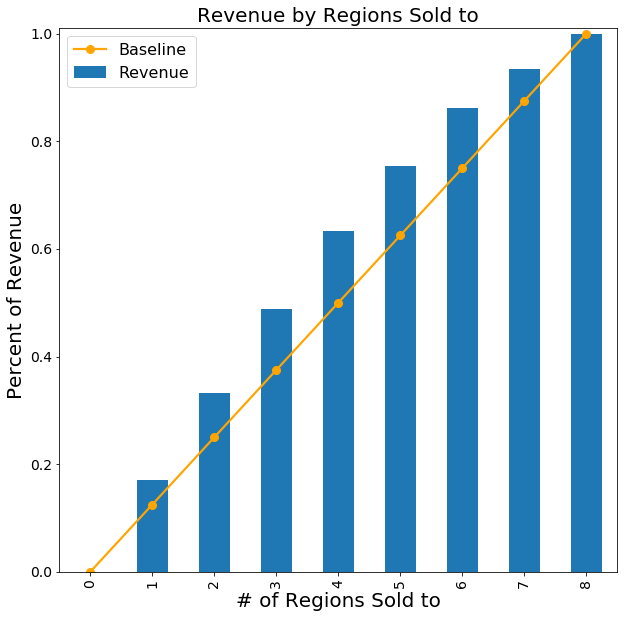

In [17]:
# Same lift curve as before, but with revenue as bars instead of a line graph

chart_values2 = chart_values.copy()
chart_values2.index += 1
ax = chart_values2.sort_index().drop(labels='VolumePercent',axis=1).plot(xlim=[0,8], ylim=[0,1.01],kind='bar',
                                                                         figsize=(10,10), fontsize=14)
t = np.arange(0.0, 9.0, 1)
ax.plot(t,t/8, marker='o', label='Baseline', lw = 2.2, markersize=8, color='orange')
ax.legend(['Baseline','Revenue'], fontsize=16)
ax.set_ylabel('Percent of Revenue', fontsize=20)
ax.set_xlabel('# of Regions Sold to', fontsize=20)
ax.set_title('Revenue by Regions Sold to', fontsize=20)

In [18]:
# Repeat the lift curve generation process, but on a city-by-city basis

# Calculate total sales
cleaned_data2 = data.copy()
cleaned_data2['4046'] = data['4046'] + data['Small Bags']
cleaned_data2['4225'] = data['4225'] + data['Large Bags']
cleaned_data2['4770'] = data['4770'] + data['XLarge Bags']
cleaned_data2 = cleaned_data2.drop(labels = ['Small Bags','Large Bags','XLarge Bags'], axis = 1)

# Remove regions and keep only cities
remove_regions = ['TotalUS', 'West', 'SouthCentral', 'Northeast', 'Southeast', 'Plains', 'Midsouth', 'GreatLakes', 'California']
indices_to_remove = data[data['region'].isin(remove_regions)].index
cleaned_data3 = cleaned_data2.drop(index=indices_to_remove)

# Calculate unmet demand
window = cleaned_data3[cleaned_data3['AveragePrice'] > .8]
max_demand = window.groupby('region').max()['Total Volume']
unmet_demand = pd.Series()
for i in max_demand.index:
    ud = max_demand[i] - cleaned_data3[cleaned_data3['region'] == i]['Total Volume']
    unmet_demand = unmet_demand.append(ud)
cleaned_data3['Unmet Demand'] = unmet_demand.sort_index()

Text(0.5,1,'Revenue by Cities Sold to')

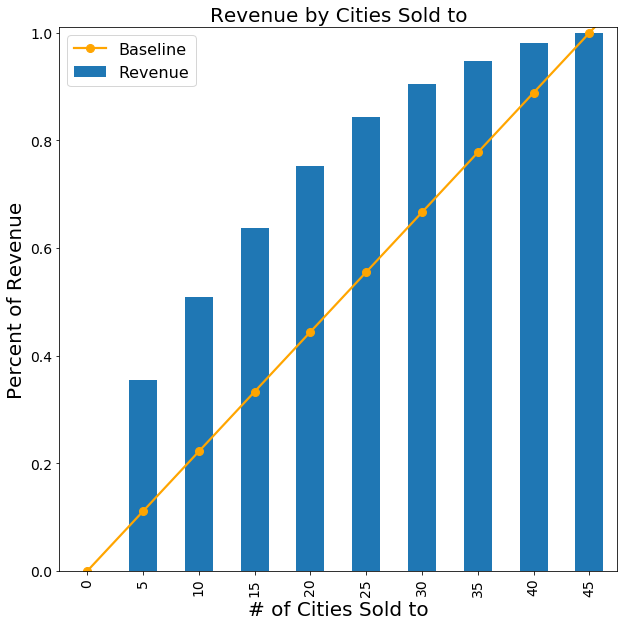

In [20]:
# Set up values for calculating lift
cleaned_data3['Revenue'] = cleaned_data3['AveragePrice']*cleaned_data3['Unmet Demand']
for_lift2 = cleaned_data3[cleaned_data3['year']==2016].groupby('region').sum().sort_values('Revenue', ascending=False)
total_values2 = for_lift2['Revenue'].sum()
for_lift2 = for_lift2.drop(['Unnamed: 0','AveragePrice','4046','4225','4770','Total Bags','year'], axis=1)
for_lift2['VolumePercent'] = for_lift2['Unmet Demand']/total_values['Unmet Demand']
for_lift2['RevenuePercent'] = for_lift2['Revenue']/total_values2
chart_values3 = for_lift2.apply(cumsum).reset_index().drop(['Unmet Demand','Total Volume','Revenue','region'], axis=1)
chart_values3.loc[-1] = [0,0]

# Create lift chart. We can see that this targeting strategy is more effective than using a regional strategy.
chart_values4 = chart_values3.copy()
chart_values4.index += 1
indices_to_lift = range(0,46,5)
ax = chart_values4.loc[indices_to_lift].sort_index().drop(labels='VolumePercent',axis=1).plot(xlim=[0,46], ylim=[0,1.01],kind='bar',
                                                                         figsize=(10,10), fontsize=14)
t = np.arange(0.0, 45.0, 1)
ax.plot(t,t/9, marker='o', label='Baseline', lw = 2.2, markersize=8, color='orange')
ax.legend(['Baseline','Revenue'], fontsize=16)
ax.set_ylabel('Percent of Revenue', fontsize=20)
ax.set_xlabel('# of Cities Sold to', fontsize=20)
ax.set_title('Revenue by Cities Sold to', fontsize=20)

In [21]:
# Find the top cities in terms of revenue (unmet demand*price point)
for_lift2['Revenue'].sort_values(ascending=False)

region
NewYork                4.462493e+08
LosAngeles             3.330965e+08
SanFrancisco           2.761533e+08
Chicago                2.391531e+08
BaltimoreWashington    1.476066e+08
MiamiFtLauderdale      1.392321e+08
PhoenixTucson          1.356704e+08
Sacramento             1.212479e+08
Denver                 1.152444e+08
WestTexNewMexico       1.133857e+08
Philadelphia           1.127656e+08
Boston                 1.104347e+08
DallasFtWorth          1.050443e+08
Seattle                9.840298e+07
Portland               9.637183e+07
NorthernNewEngland     9.599524e+07
Atlanta                9.390647e+07
Houston                9.389087e+07
Tampa                  8.947985e+07
SanDiego               8.939505e+07
Orlando                8.781259e+07
HartfordSpringfield    7.881554e+07
SouthCarolina          7.591253e+07
RaleighGreensboro      6.576701e+07
Detroit                6.138991e+07
LasVegas               5.587298e+07
GrandRapids            5.295086e+07
Charlotte            

In [22]:
# Find the top regions in terms of revenues 
for_lift['Revenue'].sort_values(ascending=False)

region
Northeast       2.408122e+08
GreatLakes      2.295550e+08
Southeast       2.190176e+08
West            2.054273e+08
California      1.696948e+08
Midsouth        1.521686e+08
SouthCentral    1.023006e+08
Plains          9.327418e+07
Name: Revenue, dtype: float64